# Run 'stockread.py' once every weekday. 
## It may take up to an hour to download data 
## (depending on net speed)

In [1]:
import sys
#!python3 stockreader.py

# Import stockdatalib

In [2]:
import stockdatalib as sd
import ipywidgets as widgets

# Must set the data subdirectory

In [3]:
# Set the data directory and the stock name
sd.set_data_directory('./data/')
sd.set_stocks_list_filename('screener_results.csv')

# Load Data and plot a stock

In [4]:
# Load S&P Stock list
stock_count, stock_fields, sp_df = sd.GetStocksList()

In [5]:
# Set stock symbol
mystock = 'abc'
sd.set_stock(mystock)

In [6]:
#
stock_info = sd.get_stock_info(mystock)
# Get stock company information
company_name = stock_info['name'][0]
company_sector = stock_info['sector'][0]
print(stock_info)

{'stock': ['abc'], 'name': ['AmerisourceBergen Corp'], 'sector': ['Health Care']}


In [7]:
# Get latest price quote
print(sd.quote('abc'))

  symbol                date  close   volume
0    abc 2020-05-15 13:30:00  85.75  1694200


In [8]:
# Get latest key stats on the stock
sd.key_stat(mystock)

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,abc,2019-12-31,0.0,4.786474e+10,229588000.0,97.580425,0.91,187640000.0,0.001577,1.231214e+09,0.366515


<Figure size 1080x432 with 0 Axes>

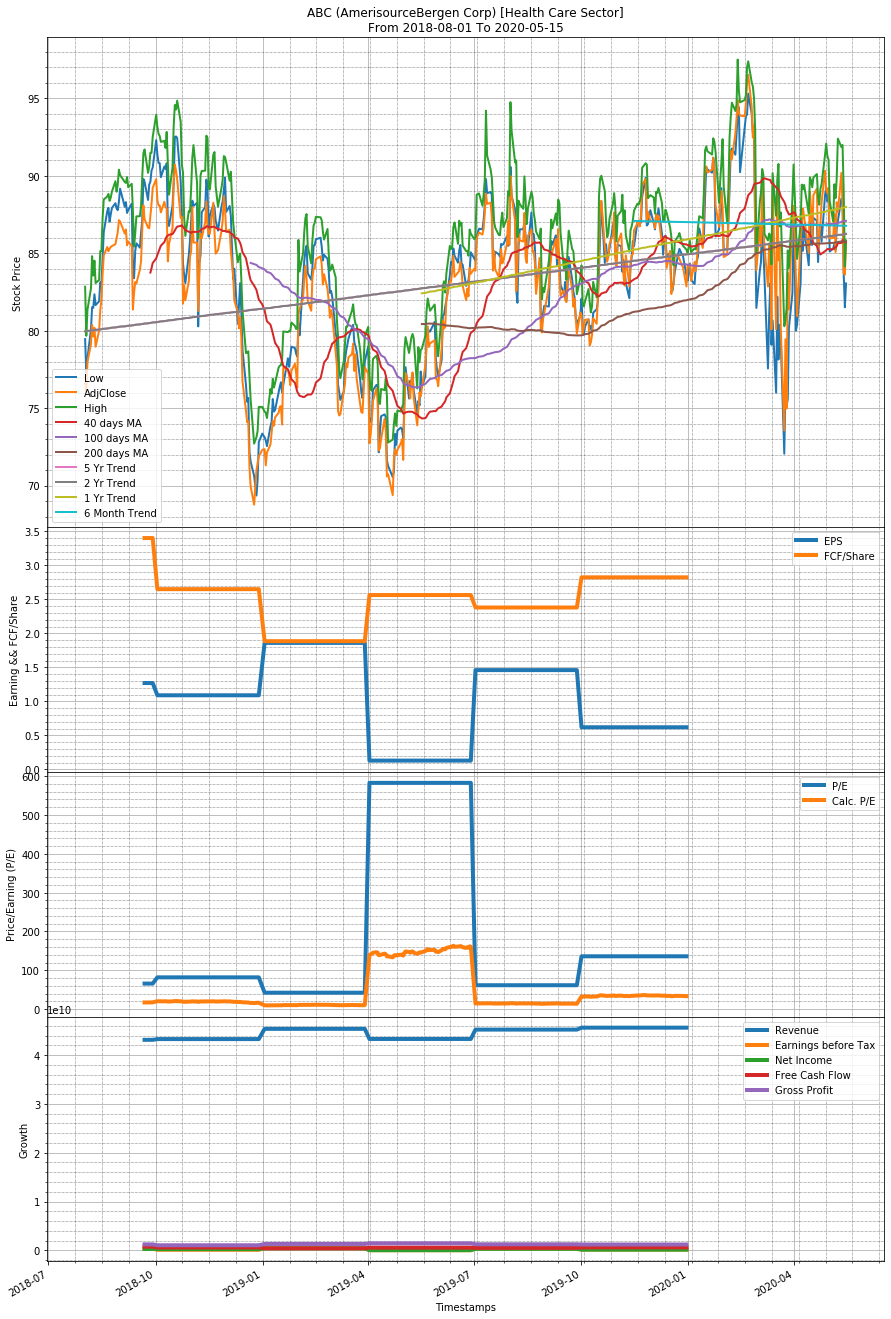

In [9]:
# Plot stock basic charts
price_df = sd.GetStockDataFrame(mystock)
price_df = sd.DatesRange(price_df, '2018-08-01') # limit the data since a specific past date or a range

linear_trends = sd.PlotBasicCharts(mystock,price_df)

In [10]:
# Linear Regression Equations returned by the plot call
linear_trends

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.01398 x + 79.96,0.01398 x + 79.96,0.0222 x + 82.41,-0.002529 x + 87.08


In [11]:
# Get last price quote
sd.quote('abc')

,symbol,date,close,volume
0,abc,2020-05-15 13:30:00,85.75,1694200


In [12]:
# Get last key stats on the stock
sd.quote('abc')

,symbol,date,close,volume
0,abc,2020-05-15 13:30:00,85.75,1694200


<Figure size 1080x432 with 0 Axes>

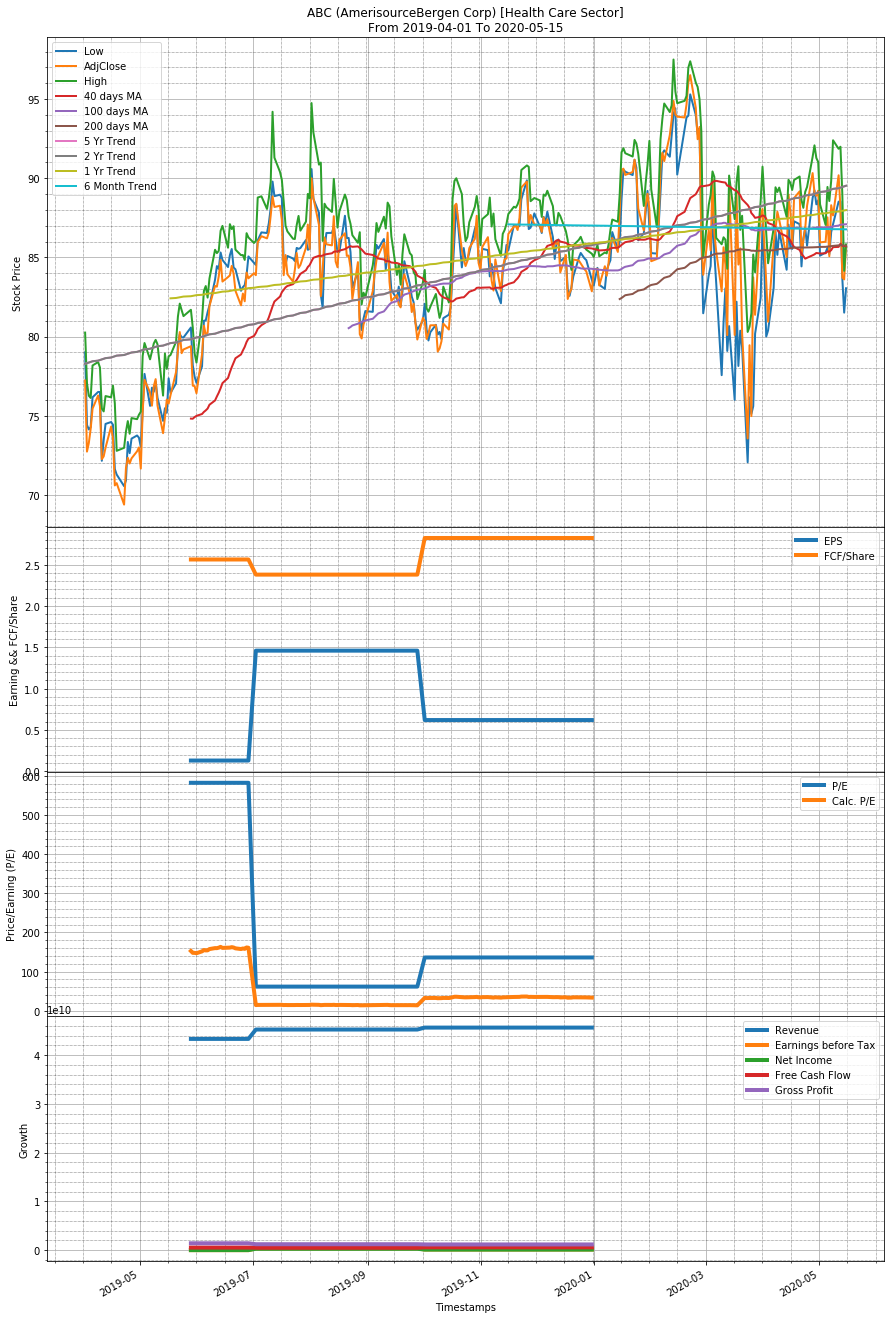

,5 Years Trend Line Function,2 Years Trend Line Function,1 Year Trend Line Function,6 Months Trend Line Function
0,0.0396 x + 78.28,0.0396 x + 78.28,0.0222 x + 82.41,-0.002529 x + 87.08


In [13]:
# Plot another stock
sd.set_stock('abc')
price_df = sd.GetStockDataFrame(sd.get_stock())
price_df_test = sd.DatesRange(price_df, '2019-04-01')
sd.PlotBasicCharts(sd.get_stock(),price_df_test)

In [14]:
sd.key_stat('abc')

,symbol,Date,No. of Shares,Revenue,Earning before Tax,PE Ratio,Earning per Share,Net Income,Free Cash Flow Margin,Gross Profit,Free Cash Flow per Share
0,abc,2019-12-31,0.0,4.786474e+10,229588000.0,97.580425,0.91,187640000.0,0.001577,1.231214e+09,0.366515


# The data load functions

In [15]:
# Load stock End of Day prices file
price_df = sd.GetStockDataFrame('abc')

# Load the stock fundamental data
keys, column_map, main_df_org = sd.GetFund_Dict('abc')
#main_df_org
column_map

{'Revenue': 'income-statement',
 'Revenue Growth': 'income-statement',
 'Cost of Revenue': 'income-statement',
 'Gross Profit': 'income-statement',
 'R&D Expenses': 'income-statement',
 'SG&A Expense': 'income-statement',
 'Operating Expenses': 'income-statement',
 'Operating Income': 'income-statement',
 'Interest Expense': 'income-statement',
 'Earnings before Tax': 'income-statement',
 'Income Tax Expense': 'income-statement',
 'Net Income - Non-Controlling int': 'income-statement',
 'Net Income - Discontinued ops': 'income-statement',
 'Net Income': 'income-statement',
 'Preferred Dividends': 'income-statement',
 'Net Income Com': 'income-statement',
 'EPS': 'income-statement',
 'EPS Diluted': 'income-statement',
 'Weighted Average Shs Out': 'income-statement',
 'Weighted Average Shs Out (Dil)': 'income-statement',
 'Dividend per Share': 'income-statement',
 'Gross Margin': 'income-statement',
 'EBITDA Margin': 'income-statement',
 'EBIT Margin': 'income-statement',
 'Profit Margin

# Searching for data by column name

In [16]:
# Search for a key word in the data column names
table,text = sd.FindColumn('Free Cash flow')
table

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Free Cash Flow,cash-flow-statement
2,Free Cash Flow per Share,company-key-metrics
3,EV to Free cash flow,company-key-metrics
4,Free Cash Flow Yield,company-key-metrics


In [103]:
import numpy as np
def GetLatestStockNumbers(stock,search_col=None):
    keys, column_map, main_df_org = sd.GetFund_Dict(stock)
    table = None  
    cols = None
    vdf = pd.DataFrame(columns=['Date Reported','Value Name','Value'])    
    if search_col != None:
        table,text = sd.FindColumn(search_col)
        cols = table['column_name'].tolist()
        #print(cols)
        
    if cols == None:
        cols = list(column_map.keys())
    
    for key in cols:
        if cols != None and key in cols:
            v = main_df_org[column_map[key]][key][-1]
            i = main_df_org[column_map[key]][key].index[-1]
            i = i.strftime("%Y-%m-%d")
            d = {'Value Name':key, 'Value':f'{round(v,4):,}','Date Reported':i}
            vdf = vdf.append(d, ignore_index=True)
        else:
            continue
        
    sq = sd.quote(stock)    
    dsprice = {'Date Reported':  sq['date'][0].strftime("%Y-%m-%d")  ,
               'Value Name':'Close Price',
               'Value':f'{round(sq["close"][0],4):,}'}
    dsvolume = {'Date Reported':sq['date'][0].strftime("%Y-%m-%d")  ,
                'Value Name':'Volume',
                'Value':f'{round(sq["volume"][0],4):,}'}
    vdf = vdf.append(dsprice, ignore_index=True)
    vdf = vdf.append(dsvolume, ignore_index=True)
    vdf = vdf.sort_values(by=['Date Reported'],ascending=[0])
    vdf.replace('', np.nan, inplace=True)
    vdf.dropna(inplace=True)
    vdf.set_index('Date Reported',inplace = True)
    return vdf

#table,text = sd.FindColumn(fcolname)
sd.set_stocks_list_filename('sp_const.csv')     
vdf = GetLatestStockNumbers('aapl')
#net_income = vdf[vdf['Value Name']=='Net Income']['Value'].iloc[0]
#vdf = GetLatestStockNumbers('aapl','Market cap')
#market_cap = vdf[vdf['Value Name']=='Market Cap']['Value'].iloc[0]
print("PE Ration = ",(float(market_cap.replace(',',''))/float(net_income.replace(',','')) )/4)
vdf

PE Ration =  27.611969883989687


,Value Name,Value
Date Reported,,
2020-05-15,Volume,"41,561,200"
2020-05-15,Close Price,307.71
2020-03-28,Interest Debt per Share,22.8452
2020-03-28,Operating Cash Flow per Share,3.0338
2020-03-28,Free Cash Flow per Share,2.6115
...,...,...
2019-09-28,debtRatios_totalDebtToCapitalization,0.5301
2019-09-28,debtRatios_cashFlowToDebtRatio,0.6799
2019-09-28,debtRatios_companyEquityMultiplier,3.741


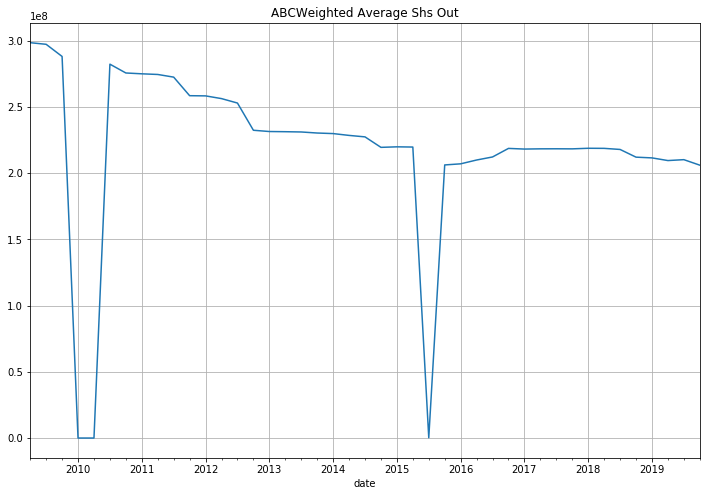

In [18]:

main_df_org['income-statement']['Weighted Average Shs Out'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+'Weighted Average Shs Out')
                                                                 

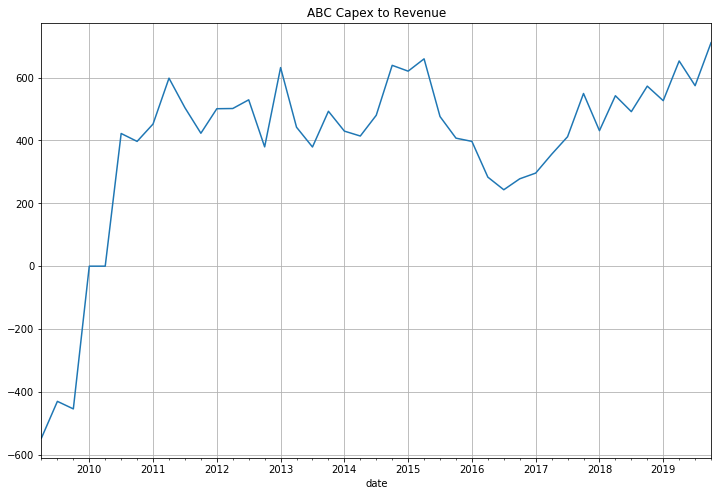

In [19]:
# Now we know where 'Capex to Revenue' is, we can load it from the DataFrame source 'company-key-metrics' as 
# the code below
main_df_org['company-key-metrics']['Capex to Revenue'].plot(figsize=(12,8),
                                                            grid=True, 
                                                            title=sd.get_stock().upper()+' Capex to Revenue')

# Selecting data range from price data frame

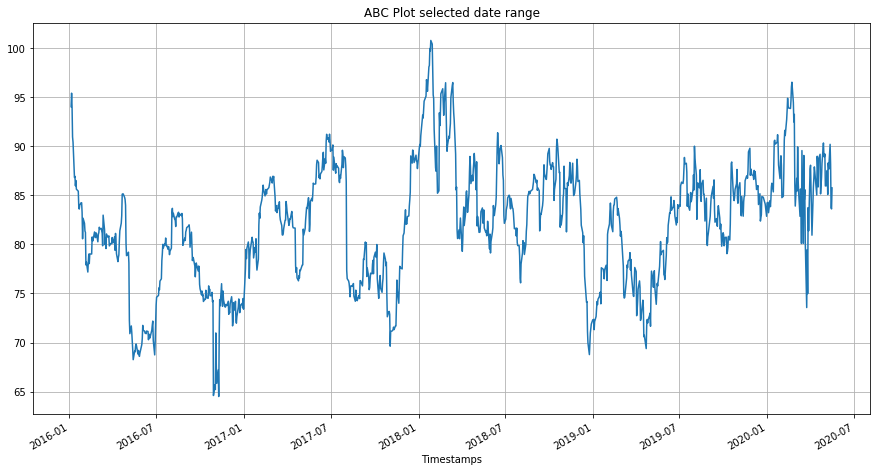

In [20]:
# Limit the stock prices data in the dates range
price_df = sd.DatesRange(price_df, '2016-01-01')

# Plot the prices chart
ax1 = price_df['AdjClose'].plot(figsize=(15,8),
                                title=sd.get_stock().upper()+" Plot selected date range").grid()

# Merging DataFrames from multiple sources into one DF

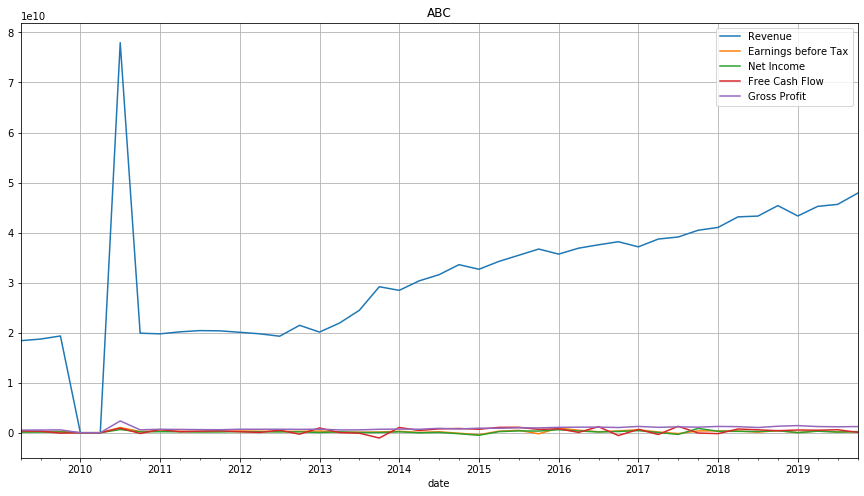

In [21]:
#
import pandas as pd

# Create a subset of columns in a DataFrame from the stock fundamentals dataset
cols = ['Revenue','Earnings before Tax','Net Income','Free Cash Flow margin','Gross Profit','Net Profit Margin'] # [ 'Shares', 'Price', 'Revenue', 'Earnings']
main_df1 = sd.MakeFund_Subset(main_df_org['income-statement'],cols)

# Create another subset of columns from another fundamentals dataset
cols = ['Number of Shares','Stock Price']
main_df2 = sd.MakeFund_Subset(main_df_org['enterprise-value'],cols)

# Create a 3rd subject of columns from yet another fundamentals dataset
cols = ['Capital Expenditure','Free Cash Flow']
main_df3 = sd.MakeFund_Subset(main_df_org['cash-flow-statement'],cols)

# Create a 4th subject of columns from yet another fundamentals dataset
cols = ['Free Cash Flow per Share']
main_df4 = sd.MakeFund_Subset(main_df_org['company-key-metrics'],cols)


# Merge the 3 dataframes into a single dataframe
main_df = pd.merge(main_df1,main_df2,on='date')
main_df = pd.merge(main_df,main_df3,on='date')
main_df = pd.merge(main_df,main_df4,on='date')

main_df.plot(y=['Revenue','Earnings before Tax','Net Income','Free Cash Flow','Gross Profit'],
             figsize=(15,8),title=sd.get_stock().upper()).grid()


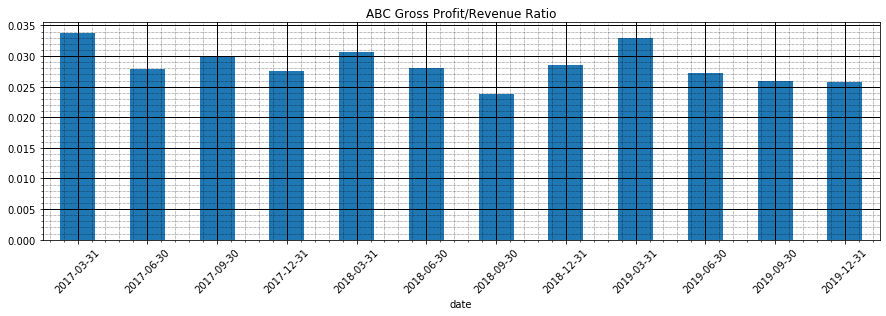

In [22]:
#
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

main_df = sd.DatesRange(main_df, '2017-01-01')
fig, ax = plt.subplots()
GrossOverRev_df = main_df['Gross Profit'] / main_df['Revenue']
ax = GrossOverRev_df.plot(ax=ax , kind='bar',
                          figsize=(15,4),
                          title=sd.get_stock().upper()+' Gross Profit/Revenue Ratio')

ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = GrossOverRev_df.index.strftime('%Y-%m-%d')
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))


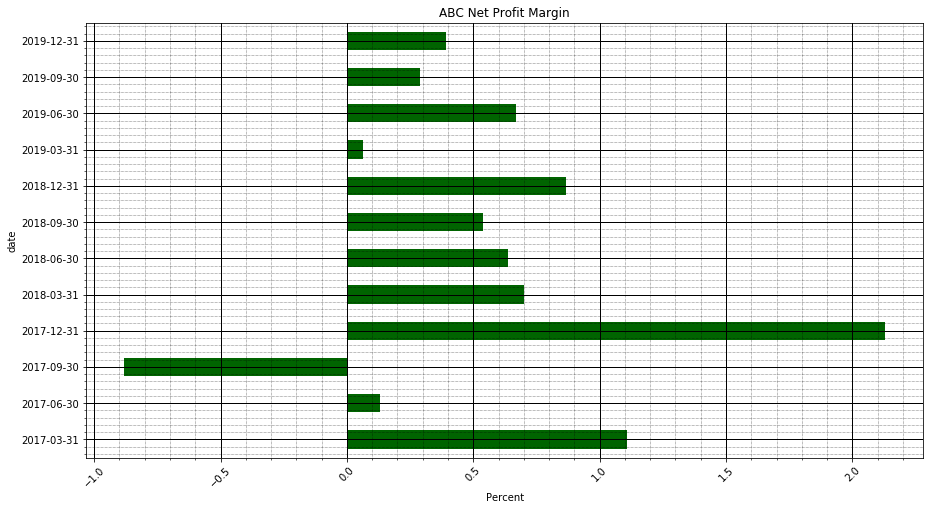

In [23]:
#
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
tmp_df = (main_df['Net Profit Margin'] * 100)
_=tmp_df.plot(ax=ax,y="Percent", kind='barh',figsize=(15,8),title=sd.get_stock().upper()+' Net Profit Margin',
              grid=True, color='darkgreen').set_xlabel('Percent')


ax.xaxis.grid( which = 'minor')
ax.grid(True)

_=plt.xticks(rotation=45)

ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.xaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')
ax.yaxis.grid(which='major', linestyle='-', linewidth='1.0', color='black')

ticklabels = tmp_df.index.strftime('%Y-%m-%d')
ax.yaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

# Using DatesRange() on fundamental data 

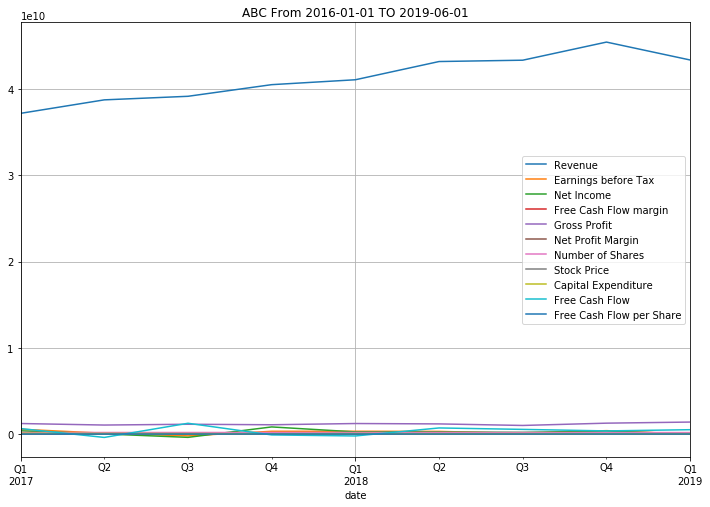

In [24]:
_=sd.DatesRange(main_df, '2016-01-01', '2019-06-01').plot(figsize=(12,8),
                                                                     grid=True,
                                                                     title=sd.get_stock().upper()+' From 2016-01-01 TO 2019-06-01')

<Figure size 1080x432 with 0 Axes>

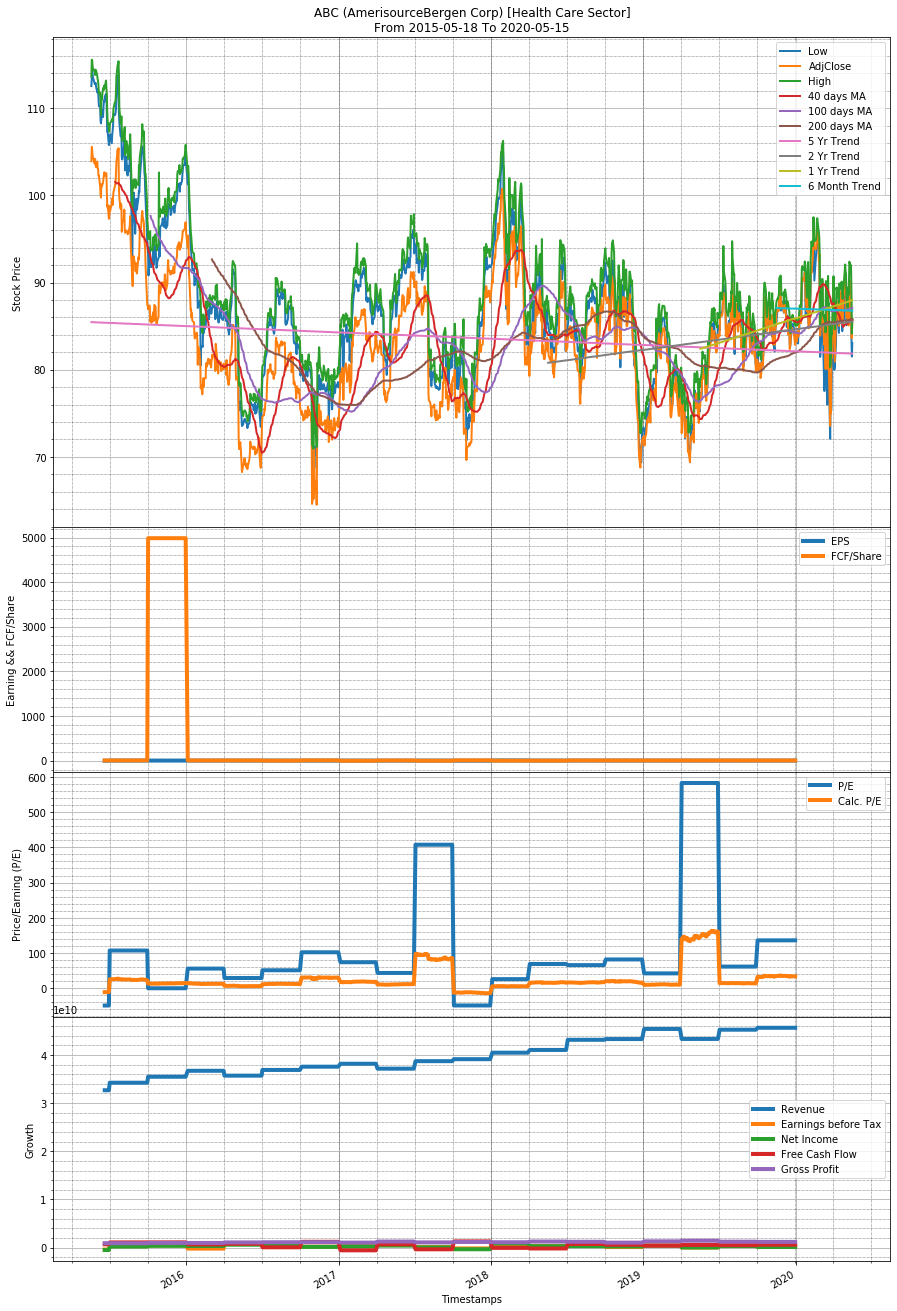

In [25]:
# Plot price chart with trend lines, EPS, and PE ratios
_=sd.PlotBasicCharts('ABC')

# Plot a single key stat item

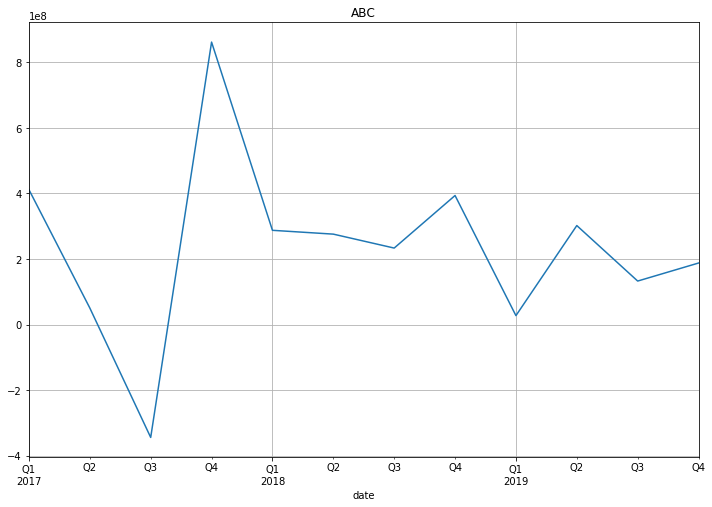

In [26]:
main_df['Net Income'].plot(figsize=(12,8), title = sd.get_stock().upper()).grid()

# Plot the TrendChart()

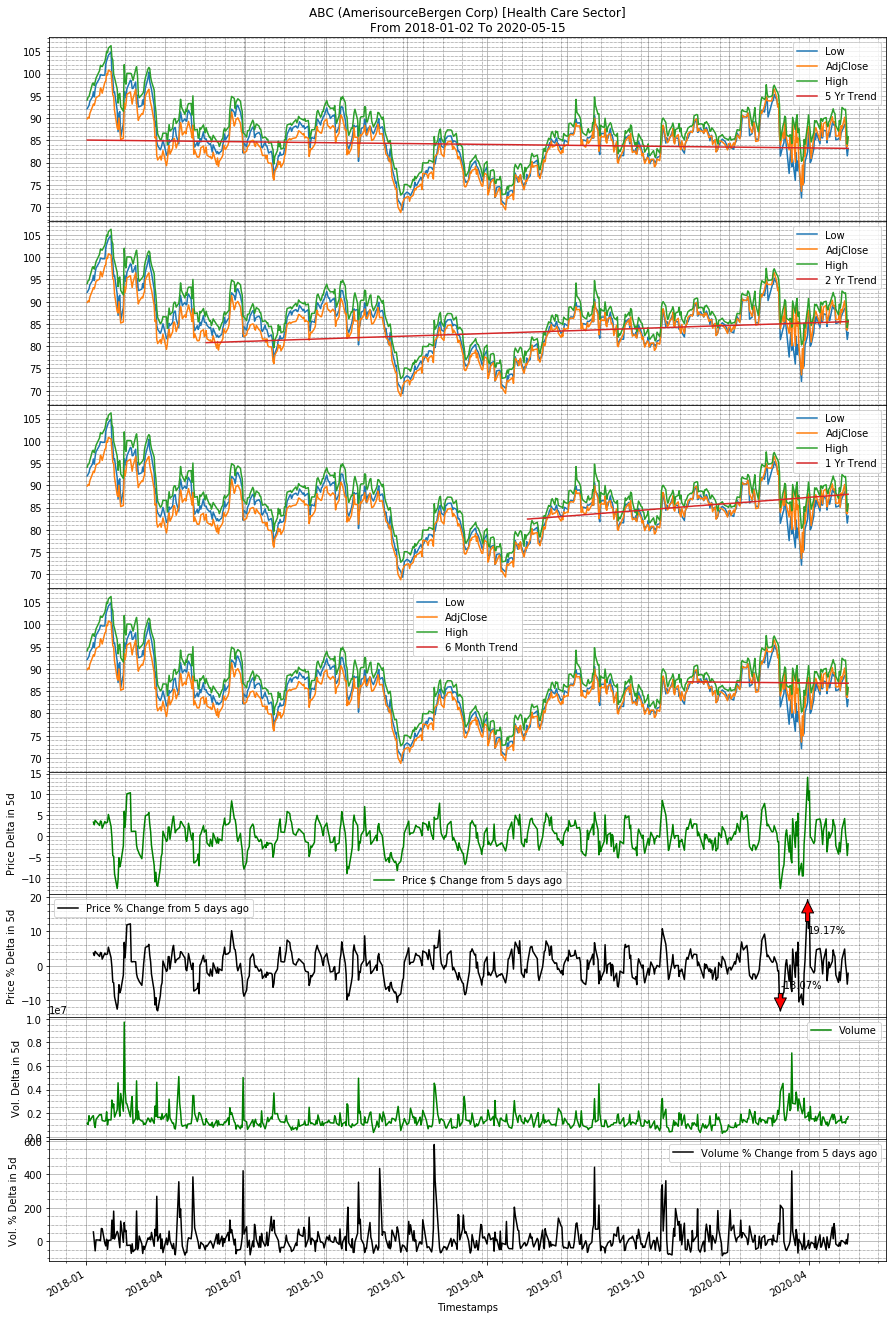

ValueError: too many values to unpack (expected 2)

In [27]:
price_df = sd.GetStockDataFrame('abc')
price_df = sd.DatesRange(price_df, '2018-01-01')
price_data_df, maximums_table_df = sd.PlotTrends('abc',price_df)

# Show the Maximums Table in price and volume

In [ ]:
maximums_table_df

In [ ]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame('abc')

# You can limit the range if needed
#price_df = sd.DatesRange(price_df, '2016-02-01')
   
sd.PlotPriceChangesPercent(price_df,[50,60,80,100,200])

In [ ]:
# Set the stock and get the prices dataframe
price_df = sd.GetStockDataFrame('jpm')
price_changes, stats = sd.PlotPriceChangesKDE(price_df,[5,10,20,50,100,200,365])
stats

In [ ]:
price_df = sd.GetStockDataFrame('abc')
sd.PlotBuySellEnvelope(price_df, 5)


In [ ]:
#
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas.plotting as pdplt
#from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('default')

sd.set_stock('abc')
price_df = sd.GetStockDataFrame(sd.get_stock())
price_df = sd.DatesRange(price_df, '2018-01-01')
df = price_df.copy(deep=True)

#split price dataframe into Training set and Test set, 80% to 20%
train_data = df[0:int(len(df)*0.8)].copy()
test_data  = df[int(len(df)*0.8):].copy()

plt.figure(figsize=(15,10))
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
plt.plot(df['Open'], 'blue', label='Training Data',lw=2.0)
plt.plot(test_data['Open'], 'green', label='Testing Data',lw=2.0)
#plt.xticks(np.arange(0,7982, 1300), df['Timestamps'][0:7982:1300])
plt.legend()
plt.grid()

In [ ]:

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

plt.figure(figsize=(15,10))
plt.grid()
pdplt.lag_plot(df['Open'], lag=3,c='b')

In [ ]:

plt.figure(figsize=(15,10))
pdplt.autocorrelation_plot(df)


In [ ]:
#
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values
history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

def PredictNextPrice():
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    return yhat[0]

In [ ]:
#
plt.figure(figsize=(15,10))

#Resize the data
train_data['Open'] = sd.DatesRange(train_data['Open'], '2019-06-01')
test_data['Open'] = sd.DatesRange(test_data['Open'], '2019-06-01')

plt.plot(train_data['Open'], 'red', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='gray', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title(sd.get_stock())
plt.xlabel('Timestamps')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,7982, 1300), df['Date'][0:7982:1300])
plt.legend()
plt.grid()

In [ ]:
print(sd.quote(sd.get_stock()).close[0])
next_price = PredictNextPrice()
print(next_price)

# Search for a column containing 'cash flow' substring

In [104]:
f,s = sd.FindColumn('cash flow')
f

,column_name,DataFrame
0,Free Cash Flow margin,income-statement
1,Operating Cash Flow,cash-flow-statement
2,Investing Cash flow,cash-flow-statement
3,Financing Cash Flow,cash-flow-statement
4,Net cash flow / Change in cash,cash-flow-statement
5,Free Cash Flow,cash-flow-statement
6,Operating Cash Flow per Share,company-key-metrics
7,Free Cash Flow per Share,company-key-metrics
8,EV to Operating cash flow,company-key-metrics
9,EV to Free cash flow,company-key-metrics


In [ ]:
fcfy_df = main_df_org['company-key-metrics']['Free Cash Flow Yield']

In [ ]:
fcfy_df.plot(figsize=(15,8))

In [ ]:
import time
def print_over(txt):
    print('\r',end='')
    print(txt,end='')
    
r,c,stocks = sd.GetStocksList()
for s in stocks['Symbol']:
    print_over(s)
    time.sleep(0.1)
    


In [ ]:
r,c,stocks = sd.GetStocksList()
stocks
for s in stocks['Symbol']:
    print_over(s)

In [ ]:
import sys
import inspect
current_module = sys.modules[__name__]

def print_classes(mod):
    for name, obj in inspect.getmembers(sys.modules[mod]):
        if inspect.isclass(obj):
            print(name,obj)

print_classes('matplotlib')           

#inspect.getmembers(sys.modules['matplotlib'])
#dir(matplotlib.pyplot)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure


class MyFigure(Figure):
    def __init__(self, *args, figtitle='hi mom', **kwargs):
        """
        custom kwarg figtitle is a figure title
        """
        super().__init__(*args, **kwargs)
        self.text(0.5, 0.95, figtitle, ha='center')


fig = plt.figure(FigureClass=MyFigure, figtitle='my title')
ax = fig.subplots()
ax.plot([1, 2, 3])

plt.show()

In [ ]:
class Animal:
    def __init__(self, Name=", Age=0, Type="):
        self.Name = Name
        self.Age = Age
        self.Type = Type
    def GetName(self):
        return self.Name
    def SetName(self, Name):
        self.Name = Name
    def GetAge(self):
        return self.Age
    def SetAge(self, Age):
        self.Age = Age
    def GetType(self):
        return self.Type
    def SetType(self, Type):
        self.Type = Type
    def __str__(self):
        return "{0} is a {1} aged {2}".format(self.Name,self.Type,self.Age)
    
class Chicken(Animal):
    def __init__(self, Name='', Age=0):
        self.Name = Name
        self.Age = Age
        self.Type = "Chicken"
    def SetType(self, Type):
        print("Sorry, {0} will always be a {1}".format(self.Name, self.Type))
    def MakeSound(self):
        print("{0} says Cluck, Cluck, Cluck!".format(self.Name))

In [ ]:
an = Chicken()
an.SetType('banana')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot


class MyPlot(plt):
    def __init__(self):
        super().__init__()
        self.plot([(1,2)])


fig = plt.plot(figtitle='my title')
ax = fig.subplots()
ax.plot([1, 2, 3])

plt.show()